<table align="center">
  <td align="center"><a target="_blank" href="http://introtodeeplearning.com">
        <img src="https://i.ibb.co/Jr88sn2/mit.png" style="padding-bottom:5px;" />
      Visit MIT Deep Learning</a></td>
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/aamini/introtodeeplearning/blob/master/lab3/Part2_BiasAndUncertainty.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/aamini/introtodeeplearning/blob/master/lab3/Part2_BiasAndUncertainty.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

# Copyright Information

In [ ]:
# Copyright 2023 MIT Introduction to Deep Learning. All Rights Reserved.
# 
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of MIT Introduction
# to Deep Learning must reference:
#
# © MIT Introduction to Deep Learning
# http://introtodeeplearning.com
#

# Laboratory 3: Debiasing, Uncertainty, and Robustness

# Part 2: Mitigating Bias and Uncertainty in Facial Detection Systems

In Lab 2, we defined a semi-supervised VAE (SS-VAE) to diagnose feature representation disparities and biases in facial detection systems. In Lab 3 Part 1, we gained experience with [Capsa](https://github.com/themis-ai/capsa/) and its ability to build risk-aware models automatically through wrapping. Now in this lab, we will put these two together: using Capsa to build systems that can *automatically* uncover and mitigate bias and uncertainty in facial detection systems.

As we have seen, automatically detecting and mitigating bias and uncertainty is crucial to deploying fair and safe models. Building off our foundation with Capsa, developed by [Themis AI](https://themisai.io/), we will now use Capsa for the facial detection problem, in order to diagnose risks in facial detection models. You will then design and create strategies to mitigate these risks, with goal of improving model performance across the entire facial detection dataset.

**Your goal in this lab -- and the associated competition -- is to design a strategic solution for bias and uncertainty mitigation, using Capsa.** The approaches and solutions with oustanding performance will be recognized with outstanding prizes! Details on the submission process are at the end of this lab.

![Capsa overview](https://raw.githubusercontent.com/aamini/introtodeeplearning/2023/lab3/img/capsa_overview.png)

Let's get started by installing the necessary dependencies:

In [1]:
# Import Tensorflow 2.0
#%tensorflow_version 2.x
import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Download and import the MIT 6.S191 package
!pip install git+https://github.com/aamini/introtodeeplearning.git@2023
import mitdeeplearning as mdl

# Download and import capsa
!pip install capsa
import capsa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/aamini/introtodeeplearning.git (to revision 2023) to /tmp/pip-req-build-7i2lc79h
  Running command git clone --filter=blob:none --quiet https://github.com/aamini/introtodeeplearning.git /tmp/pip-req-build-7i2lc79h
  Running command git checkout -b 2023 --track origin/2023
  Switched to a new branch '2023'
  Branch '2023' set up to track remote branch '2023' from 'origin'.
  Resolved https://github.com/aamini/introtodeeplearning.git to commit ed7501323f5b3f0f865db898b1ce6a0528df1586
  Preparing metadata (setup.py) ... done
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.4.0-py3-none-any.whl size=2118524 sha256=459fb31168bfbed19e120aed16ed5ef510db7d79f0898b868490777243f50477
  Stored in directory: /tmp/pip-ephem-wheel-cache-nf2u0pc5/wheels/39/e7/cb/0a55c67138c508afc5c54b931de928c1be1822d5027c7d88b9
Successfully built mitdeeplearning
Looking in in

# 3.1 Datasets

Since we are again focusing on the facial detection problem, we will use the same datasets from Lab 2. To remind you, we have a dataset of positive examples (i.e., of faces) and a dataset of negative examples (i.e., of things that are not faces).

1.   **Positive training data**: [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). A large-scale dataset (over 200K images) of celebrity faces.   
2.   **Negative training data**: [ImageNet](http://www.image-net.org/). A large-scale dataset with many images across many different categories. We will take negative examples from a variety of non-human categories.

We will evaluate trained models on an independent test dataset of face images to diagnose and mitigate potential issues with *bias, fairness, and confidence*. This will be a larger test dataset for evaluation purposes.

We begin by importing these datasets. We have defined a `DatasetLoader` class that does a bit of data pre-processing to import the training data in a usable format.

In [2]:
batch_size = 32

# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face_2023_perturbed_small.h5', 'https://www.dropbox.com/s/tbra3danrk5x8h5/train_face_2023_perturbed_small.h5?dl=1')
# Instantiate a DatasetLoader using the downloaded dataset
train_loader = mdl.lab3.DatasetLoader(path_to_training_data, training=True, batch_size=batch_size)
test_loader = mdl.lab3.DatasetLoader(path_to_training_data, training=False, batch_size=batch_size)

675368621/675368621 [==============================] - 41s 0us/step
Opening /root/.keras/datasets/train_face_2023_perturbed_small.h5
Loading data into memory...
Opening /root/.keras/datasets/train_face_2023_perturbed_small.h5
Loading data into memory...


### Building robustness to bias and uncertainty

Remember that we'll be training our facial detection classifiers on the large, well-curated CelebA dataset (and ImageNet), and then evaluating their accuracy by testing them on an independent test dataset. We want to mitigate the effects of unwanted bias and uncertainty on the model's predictions and performance. Your goal is to build the best-performing, most robust model, one that achieves high classification accuracy across the entire test dataset.

To achieve this, you may want to consider the three metrics introduced with Capsa: (1) representation bias, (2) data or aleatoric uncertainty, and (3) model or epistemic uncertainty. Note that all three of these metrics are different! For example, we can have well-represented examples that still have high epistemic uncertainty. Think about how you may use these metrics to improve the performance of your model.

# 3.2 Risk-aware facial detection with Capsa

In Lab 2, we built a semi-supervised variational autoencoder (SS-VAE) to learn the latent structure of our database and to uncover feature representation disparities, inspired by the approach of [uncover hidden biases](http://introtodeeplearning.com/AAAI_MitigatingAlgorithmicBias.pdf). In this lab, we'll show that we can use Capsa to build the same VAE in one line!

This sets the foundation for quantifying a key risk metric -- representation bias -- for the facial detection problem. In working to improve your model's performance, you will want to consider representation bias carefully and think about how you could mitigate the effect of representation bias.

Just like in Lab 2, we begin by defining a standard CNN-based classifier. We will then use Capsa to wrap the model and build the risk-aware VAE variant.

In [3]:
### Define the CNN classifier model ###

'''Function to define a standard CNN model'''
def make_standard_classifier(n_outputs=1, n_filters=12):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([ 
    tf.keras.Input(shape=(64,64, 3)),
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),
    
    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=8*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model

### Capsa's `HistogramVAEWrapper`

With our base classifier Capsa allows us to automatically define a VAE implementing that base classifier. Capsa's [`HistogramVAEWrapper`](https://themisai.io/capsa/api_documentation/HistogramVAEWrapper.html) builds this VAE to analyze the latent space distribution, just as we did in Lab 2. 

Specifically, `capsa.HistogramVAEWrapper` constructs a histogram with `num_bins` bins across every dimension of the latent space, and then calculates the joint probability of every sample according to the constructed histograms. The samples with the lowest joint probability have the lowest representation; the samples with the highest joint probability have the highest representation.

`capsa.HistogramVAEWrapper` takes in a number of arguments including:
1. `base_model`: the model to be transformed into the risk-aware variant.
2. `num_bins`: the number of bins we want to discretize our distribution into. 
2. `queue_size`: the number of samples we want to track at any given point.
3. `decoder`: the decoder architecture for the VAE.

We define the same decoder as in Lab 2:

In [4]:
### Define the decoder architecture for the facial detection VAE ###

def make_face_decoder_network(n_filters=12):
  # Functionally define the different layer types we will use
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, 
                                      padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  # Build the decoder network using the Sequential API
  decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=2*2*8*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(2, 2, 8*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=6*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

We are ready to create the wrapped model using `capsa.HistogramVAEWrapper` by passing in the relevant arguments!

Just like in the wrappers in the Introduction to Capsa lab, we can take our standard CNN classifier, wrap it with `capsa.HistogramVAEWrapper`, build the wrapped model. The wrapper then enablings semi-supervised training for the facial detection task. As the wrapped model trains, the classifier weights are updated, and the VAE-wrapped model learns to track feature distributions over the latent space. More details of the `HistogramVAEWrapper` and how it can be used are [available here](https://themisai.io/capsa/api_documentation/HistogramVAEWrapper.html).

We can then evaluate the representation bias of the classifier on the test dataset. By calling the `wrapped_model` on our test data, we can automatically generate representation bias and uncertainty scores that are normally manually calculated. Let's wrap our base CNN classifier using Capsa, train and build the resulting model, and start to process the test data: 

In [5]:
### Estimating representation bias with Capsa HistogramVAEWrapper ###

model = make_standard_classifier()
# Wrap the CNN classifier for latent encoding with a VAE wrapper
wrapped_model = capsa.HistogramVAEWrapper(model, num_bins=5, queue_size=20000, 
    latent_dim = 32, decoder=make_face_decoder_network())

# Build the model for classification, defining the loss function, optimizer, and metrics
wrapped_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # for classification
    metrics=[tf.keras.metrics.BinaryAccuracy()], # for classification
    run_eagerly=True
)

# Train the wrapped model for 6 epochs by fitting to the training data
history = wrapped_model.fit(
        train_loader,
        epochs=6,
        batch_size=batch_size,
  )

## Evaluation

# Get all faces from the testing dataset
test_imgs = test_loader.get_all_faces()

# Call the Capsa-wrapped classifier to generate outputs: predictions, uncertainty, and bias!
predictions, uncertainty, bias = wrapped_model.predict(test_imgs, batch_size=512)

Epoch 1/6


1373/1373 [==============================] - 15s 9ms/step - vae_compiled_loss: 0.4330 - vae_compiled_binary_accuracy: 0.7882 - vae_wrapper_loss: 369.4506
Epoch 2/6
1373/1373 [==============================] - 13s 9ms/step - vae_compiled_loss: 0.3146 - vae_compiled_binary_accuracy: 0.8665 - vae_wrapper_loss: 212.3673
Epoch 3/6
1373/1373 [==============================] - 12s 9ms/step - vae_compiled_loss: 0.2946 - vae_compiled_binary_accuracy: 0.8818 - vae_wrapper_loss: 189.5968
Epoch 4/6
1373/1373 [==============================] - 12s 9ms/step - vae_compiled_loss: 0.2882 - vae_compiled_binary_accuracy: 0.8876 - vae_wrapper_loss: 177.5118
Epoch 5/6
1373/1373 [==============================] - 12s 9ms/step - vae_compiled_loss: 0.2849 - vae_compiled_binary_accuracy: 0.8890 - vae_wrapper_loss: 172.3526
Epoch 6/6
9/9 [==============================] - 2s 140ms/step


# 3.3 Analyzing representation bias with Capsa

From the above output, we have an estimate for the representation bias score! We can analyze the representation scores to start to think about manifestations of bias in the facial detection dataset. Before you run the next code block, which faces would you expect to be underrepresented in the dataset? Which ones do you think will be overrepresented?

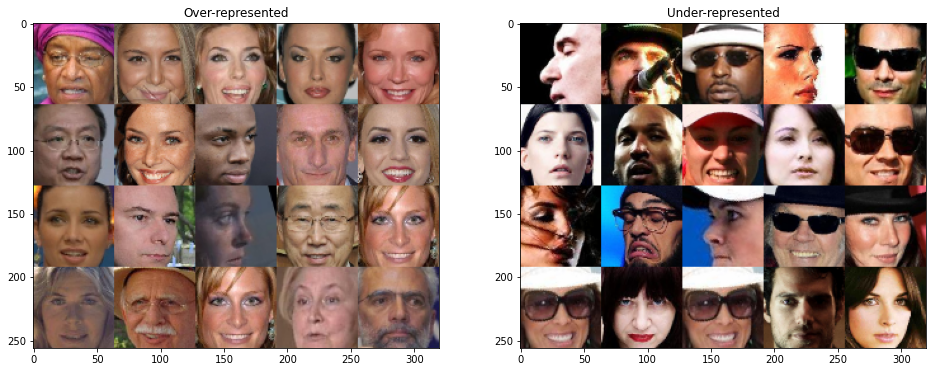

In [6]:
### Analyzing representation bias scores ###

# Sort according to lowest to highest representation scores
indices = np.argsort(bias, axis=None) # sort the score values themselves
sorted_images = test_imgs[indices] # sort images from lowest to highest representations
sorted_biases = bias[indices] # order the representation bias scores
sorted_preds = predictions[indices] # order the prediction values


# Visualize the 20 images with the lowest and highest representation in the test dataset
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(mdl.util.create_grid_of_images(sorted_images[-20:], (4, 5)))
ax[0].set_title("Over-represented")

ax[1].imshow(mdl.util.create_grid_of_images(sorted_images[:20], (4, 5)))
ax[1].set_title("Under-represented");

We can also quantify how the representation density relates to the classification accuracy by plotting the two against each other:

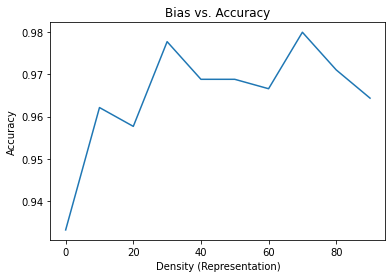

<Figure size 432x288 with 0 Axes>

In [7]:
# Plot the representation density vs. the accuracy
plt.xlabel("Density (Representation)")
plt.ylabel("Accuracy")
averaged_imgs = mdl.lab3.plot_accuracy_vs_risk(sorted_images, sorted_biases, sorted_preds, "Bias vs. Accuracy")

These representations scores relate back to data examples, so we can visualize what the average face looks like for a given *percentile* of representation density:

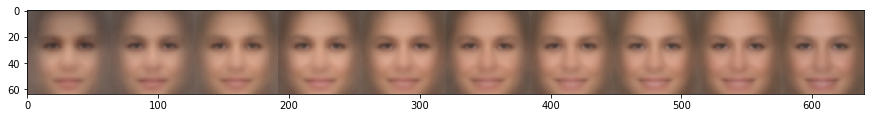

In [8]:
fig, ax = plt.subplots(figsize=(15,5))
ax.imshow(mdl.util.create_grid_of_images(averaged_imgs, (1,10)))

#### **TODO: Scoring representation densities with Capsa**

Write short answers to the questions below to complete the `TODO`s:

1. How does accuracy relate to the representation score? From this relationship, what can you determine about the bias underlying the dataset?
2. What does the average face in the 10th percentile of representation density look like (i.e., the face for which 10% of the data have lower probability of occuring)? What about the 90th percentile? What changes across these faces?
3. What could be potential limitations of the `HistogramVAEWrapper` approach as it is implemented now?

# 3.4 Analyzing epistemic uncertainty with Capsa

Recall that *epistemic* uncertainty, or a model's uncertainty in its prediction, can arise from out-of-distribution data, missing data, or samples that are harder to learn. This does not necessarily correlate with representation bias! Imagine the scenario of training an object detector for self-driving cars: even if the model is presented with many cluttered scenes, these samples still may be harder to learn than scenes with very few objects in them.

We will now use our VAE-wrapped facial detection classifier to analyze and estimate the epistemic uncertainty of the model trained on the facial detection task.

While most methods of estimating epistemic uncertainty are *sampling-based*, we can also use ***reconstruction-based*** methods -- like using VAEs -- to estimate epistemic uncertainty. If a model is unable to provide a good reconstruction for a given data point, it has not learned that area of the underlying data distribution well, and therefore has high epistemic uncertainty.



Since we've already used the `HistogramVAEWrapper` to calculate the histograms for representation bias quantification, we can use the exact same VAE wrapper to shed insight into epistemic uncertainty! Capsa helps us do exactly that. When we called the model, we returned the classification prediction, uncertainty, and bias for every sample:
`predictions, uncertainty, bias = wrapped_model.predict(test_imgs, batch_size=512)`.

Let's analyze these estimated uncertainties:

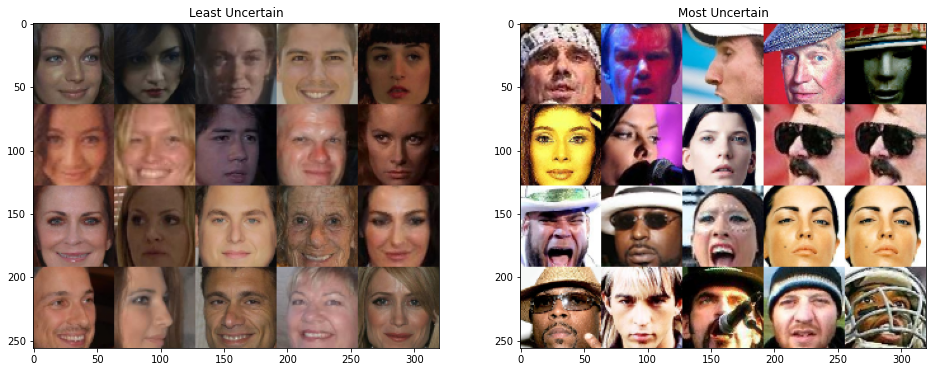

In [9]:
### Analyzing epistemic uncertainty estimates ###

# Sort according to epistemic uncertainty estimates
epistemic_indices = np.argsort(uncertainty, axis=None) # sort the uncertainty values
epistemic_images = test_imgs[epistemic_indices] # sort images from lowest to highest uncertainty
sorted_epistemic = uncertainty[epistemic_indices] # order the uncertainty scores
sorted_epistemic_preds = predictions[epistemic_indices] # order the prediction values


# Visualize the 20 images with the LEAST and MOST epistemic uncertainty
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(mdl.util.create_grid_of_images(epistemic_images[:20], (4, 5)))
ax[0].set_title("Least Uncertain");

ax[1].imshow(mdl.util.create_grid_of_images(epistemic_images[-20:], (4, 5)))
ax[1].set_title("Most Uncertain");

We quantify how the epistemic uncertainty relates to the classification accuracy by plotting the two against each other:

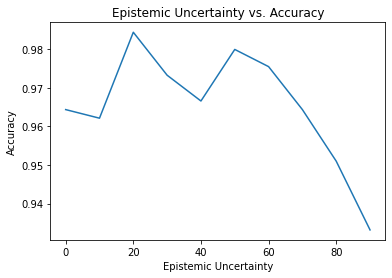

<Figure size 432x288 with 0 Axes>

In [10]:
# Plot epistemic uncertainty vs. classification accuracy
plt.xlabel("Epistemic Uncertainty")
plt.ylabel("Accuracy")
_ = mdl.lab3.plot_accuracy_vs_risk(epistemic_images, sorted_epistemic, sorted_epistemic_preds, "Epistemic Uncertainty vs. Accuracy")

#### **TODO: Estimating epistemic uncertainties with Capsa**

Write short answers to the questions below to complete the `TODO`s:

1. How does accuracy relate to the epistemic uncertainty?
2. How do the results for epistemic uncertainty compare to the results for representation bias? Was this expected or unexpted? Why?
3. What may be instances in the facial detection task that could have high representation density but also high uncertainty? 

# 3.4 Resampling based on risk metrics

Finally, we will use the risk metrics just computed to actually *mitigate* the issues of bias and uncertainty in the facial detection classifier.

Specifically, we will use the latent variables learned via the VAE to adaptively re-sample the face (CelebA) data during training, following the approach of [recent work](http://introtodeeplearning.com/AAAI_MitigatingAlgorithmicBias.pdf). We will alter the probability that a given image is used during training based on how often its latent features appear in the dataset. So, faces with rarer features (like dark skin, sunglasses, or hats) should become more likely to be sampled during training, while the sampling probability for faces with features that are over-represented in the training dataset should decrease (relative to uniform random sampling across the training data).

Note that we want to debias and amplify only the *positive* samples in the dataset -- the faces -- so we are going to only adjust probabilities and calculate scores for these samples. We focus on using the representation bias scores to implement this adaptive resampling to achieve model debiasing.

We re-define the wrapped model with `HistogramVAEWrapper`, and then define the adaptive resampling operation for training. At each training epoch, we compute the predictions, uncertainties, and representation bias scores, then recompute the data sampling probabilities according to the *inverse* of the representation bias score. That is, samples with higher representation densities will end up with lower re-sampling probabilities; samples with lower representations will end up with higher re-sampling probabilities.

Let's do all this below!

In [11]:
### Define the standard CNN classifier and wrap with HistogramVAE ###

classifier = make_standard_classifier()
# Wrap with HistogramVAE
wrapper = capsa.HistogramVAEWrapper(classifier, latent_dim=32, num_bins=5, 
                          queue_size=2000, decoder=make_face_decoder_network())

# Build the wrapped model for the classification task
wrapper.compile(optimizer=tf.keras.optimizers.Adam(5e-4),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=[tf.keras.metrics.BinaryAccuracy()])

# Load training data
train_imgs = train_loader.get_all_faces()

In [12]:
### Debiasing via resampling based on risk metrics ###

# The training loop -- outer loop iterates over the number of epochs
num_epochs = 6
for i in range(num_epochs):
  print("Starting epoch {}/{}".format(i+1, num_epochs))
  
  # Get a batch of training data and compute the training step
  for step, data in enumerate(train_loader):
    metrics = wrapper.train_step(data)
    if step % 100 == 0:
        print(step)

  # After the epoch is done, recompute data sampling proabilities 
  #  according to the inverse of the bias
  pred, unc, bias = wrapper(train_imgs)

  # Increase the probability of sampling under-represented datapoints by setting 
  #   the probability to the **inverse** of the biases
  inverse_bias = 1.0 / (bias.numpy() + 1e-7)

  # Normalize the inverse biases in order to convert them to probabilities
  p_faces = inverse_bias / np.sum(inverse_bias)

  # Update the training data loader to sample according to this new distribution
  train_loader.p_pos = p_faces

Starting epoch 1/6


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
Starting epoch 2/6
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
Starting epoch 3/6
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
Starting epoch 4/6
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
Starting epoch 5/6
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
Starting epoch 6/6
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


That's it! We should have a debiased model (we hope!). Let's see how the model does.

### Evaluation

Let's run the same analyses as before, and plot the classification accuracy vs. the representation bias and classification accuracy vs. epistemic uncertainty. We want the model to do better across the data samples, achieving higher accuracies on the under-represented and more uncertain samples compared to previously.


141/141 [==============================] - 3s 19ms/step


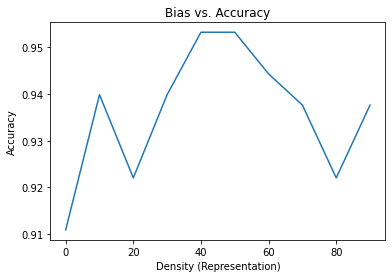

<Figure size 432x288 with 0 Axes>

In [13]:
### Evaluation of debiased model ###

# Get classification predictions, uncertainties, and representation bias scores
pred, unc, bias = wrapper.predict(test_imgs)

# Sort according to lowest to highest representation scores
indices = np.argsort(bias, axis=None)
bias_images = test_imgs[indices] # sort the images
sorted_bias = bias[indices] # sort the representation bias scores
sorted_bias_preds = pred[indices] # sort the predictions

# Plot the representation bias vs. the accuracy
plt.xlabel("Density (Representation)")
plt.ylabel("Accuracy")
_ = mdl.lab3.plot_accuracy_vs_risk(bias_images, sorted_bias, sorted_bias_preds, "Bias vs. Accuracy")

# 3.5 Competition!

Now, you are well equipped to submit to the competition to dig in deeper into deep learning models, uncover their deficiencies with Capsa, address those deficiencies, and submit your findings!

**Below are some potential areas to start investigating -- the goal of the competition is to develop creative and innovative solutions to address bias and uncertainty, and to improve the overall performance of deep learning models.**

We encourage you to identify other questions that could be solved with Capsa and use those as the basis of your submission. But, to help get you started, here are some interesting questions that you might look into solving with these new tools and knowledge that you've built up: 

1. In this lab, you learned how to build a wrapper that can estimate the bias within the training data, and take the results from this wrapper to adaptively re-sample during training to encourage learning on under-represented data. 
  * Can we apply a similar approach to mitigate epistemic uncertainty in the model? 
  * Can this approach be combined with your original bias mitigation approach to achieve robustness across both bias *and* uncertainty? 

2. In this lab, you focused on the `HistogramVAEWrapper`. 
  * How can you use other methods of uncertainty in Capsa to strengthen your uncertainty estimates? Checkout [Capsa documentation](https://themisai.io/capsa/api_documentation/index.html) for a list of all wrappers, and ask for help if you run into trouble applying them to your model!
  * Can you combine uncertainty estimates from different wrappers to achieve greater robustness in your estimates? 

3. So far in this part of the lab, we focused only on bias and epistemic uncertainty. What about aleatoric uncetainty? 
  * We've curated a dataset (available at [this URL](https://www.dropbox.com/s/wsdyma8a340k8lw/train_face_2023_perturbed_large.h5?dl=0)) of faces with greater amounts of aleatoric uncertainty -- can you use Capsa to wrap your model, estimate aleatoric uncertainty, and remove it from the dataset? 
  * Does removing aleatoric uncertainty help improve your training accuracy on this new dataset? 
  * Can you develop an approach to incorporate this aleatoric uncertainty estimation into the predictive training pipeline in order to improve accuracy? You may find some surprising results!!

4. How can the performance of the classifier above be improved even further? We purposely did not optimize hyperparameters to leave this up to you!

5. Are there other applications that you think Capsa and bias/uncertainty estimation would be helpful in? 
  * Try integrating Capsa into another domain or dataset and submit your findings!
  * Are there applications where you may *not* want to debias your model? 


**To enter the competition, please upload the following to the [lab submission site](https://www.dropbox.com/request/TTYz3Ikx5wIgOITmm5i2):**

* Written short-answer responses to `TODO`s from Lab 2, Part 2 on Facial Detection.
* Description of the wrappers, algorithms, and approach you used. What was your strategy? What wrappers did you implement? What debiasing or mitigation strategies did you try? How and why did these modifications affect performance? Describe *any* modifications or implementations you made to the template code, and what their effects were. Written text, visual diagram, and plots welcome!
* Jupyter notebook with the code you used to generate your results (along with all plots/visuals generated).

**Name your file in the following format: `[FirstName]_[LastName]_Face`, followed by the file format (.zip, .ipynb, .pdf, etc).** ZIP files are preferred over individual files. If you submit individual files, you must name the individual files according to the above nomenclature (e.g., `[FirstName]_[LastName]_Face_TODO.pdf`, `[FirstName]_[LastName]_Face_Report.pdf`, etc.). **Submit your files [here](https://www.dropbox.com/request/TTYz3Ikx5wIgOITmm5i2).**

We encourage you to think about and maybe even address some questions raised by this lab and dig into any questions that you may have about the risks inherrent to neural networks and their data. 

<img src="https://i.ibb.co/BjLSRMM/ezgif-2-253dfd3f9097.gif" />